In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging
                            )

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp


plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'

## Load Data

a. GMT data

In [2]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

b. GDP data

In [3]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Refp5', 'scen'] = 'Ref1p5'
gdp_df['run'] = [f.split('_')[-1] for f in gdp_df['run']]
gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_df.reset_index(drop = True, inplace = True)

## Analysis

### Step 1: GDP development over time

In [4]:
# estimate GDP development 
def q1(x):
    return x.quantile(0.1)
def q9(x):
    return x.quantile(0.9)

def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)
# derive differences
gdp_ref = gdp_df[gdp_df.scen == 'Ref'].copy()
gdp_neg = gdp_df[gdp_df.scen == 'Neg'].copy()
gdp_gs = gdp_df[gdp_df.scen == 'GS'].copy()

# derive timeseries of of 10th, median and 90th percentile: 
f = {'diff_SSP2': ['median', 'std', q1, q9, q05, q95]}
gdp_ref_agg = gdp_ref.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()
gdp_neg_agg = gdp_neg.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()

In [5]:
ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
gs_quantiles = np.quantile(gdp_gs[gdp_gs.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100

### Step 2: Hypothesis testing: Are the Ref and Neg distributions significantly different? 

a. Employ KS test to see if Neg and Ref distributions are significantly different

In [6]:
for year in [2040,2050,2060,2070,2080,2090,2100]: 
  gdp_year_ref = gdp_ref[gdp_ref.year == year]
  gdp_year_neg = gdp_neg[gdp_neg.year == year]
  print(f'Year: {year}',   ks_2samp(gdp_year_ref.loc[:, 'diff_SSP2'].values.flatten(), 
          gdp_year_neg.loc[:, 'diff_SSP2'].values.flatten(), 
          alternative= 'two-sided'
        ))
  # KS test: p-value < 0.05, reject null hypothesis that the two samples are drawn from the same distribution

Year: 2040 KstestResult(statistic=0.05987261146496814, pvalue=6.647472322223341e-25)
Year: 2050 KstestResult(statistic=0.0672611464968153, pvalue=2.537158552051428e-31)
Year: 2060 KstestResult(statistic=0.05662420382165606, pvalue=2.5569455402793708e-22)
Year: 2070 KstestResult(statistic=0.06751592356687897, pvalue=1.47799905382289e-31)
Year: 2080 KstestResult(statistic=0.025222929936305732, pvalue=9.023607372943167e-05)
Year: 2090 KstestResult(statistic=0.010955414012738918, pvalue=0.3006166064039584)
Year: 2100 KstestResult(statistic=0.015668789808917227, pvalue=0.04192252506855554)


b. Are two randomly chosen subpopulations from ref & neg that have the same eoc temperature significantly different?

2040 KstestResult(statistic=0.1111111111111111, pvalue=0.7695469627551301)
2050 KstestResult(statistic=0.08333333333333333, pvalue=0.9658981488800277)
2060 KstestResult(statistic=0.08333333333333333, pvalue=0.9658981488800277)
2070 KstestResult(statistic=0.1111111111111111, pvalue=0.7695469627551301)
2080 KstestResult(statistic=0.08333333333333333, pvalue=0.9658981488800277)
2090 KstestResult(statistic=0.1527777777777778, pvalue=0.37219871164407936)
2100 KstestResult(statistic=0.1111111111111111, pvalue=0.7695469627551301)


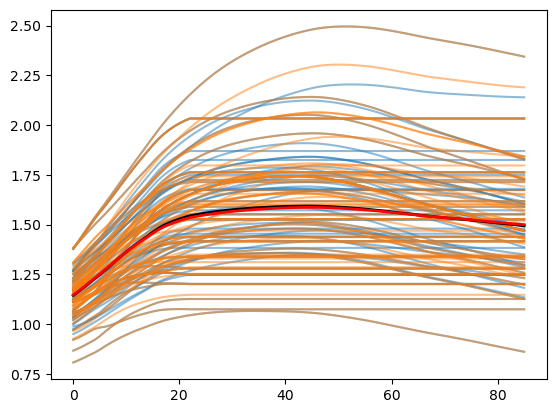

In [7]:
import random 
run_group_a = random.sample(range(0,200), 100)
run_group_b = [i for i in range(200) if i not in run_group_a]

for year in [2040,2050,2060,2070,2080,2090,2100]:
    gmt_ref_a = gmt_ds.loc[:, (gmt_ds.columns.str.contains('Ref')) | (gmt_ds.columns.str.contains('Neg'))].iloc[:, run_group_a].copy().values
    gmt_ref_b = gmt_ds.loc[:,(gmt_ds.columns.str.contains('Ref')) | (gmt_ds.columns.str.contains('Neg'))].iloc[:, run_group_b].copy().values
    gdp_2100_test = gdp_df[ ((gdp_df.scen == 'Ref') | (gdp_df.scen == 'Neg')) & (gdp_df.year == year)].copy()

    ref_pairs  = []
    err = 0.05
    for i in range(gmt_ref_a.shape[1]):
        for j in range(gmt_ref_b.shape[1]):
            if len(ref_pairs) == 0: 
                if (np.abs(gmt_ref_a[0,i]-gmt_ref_b[0,j]) <= err) & (np.abs(gmt_ref_a[-1,i]-gmt_ref_b[-1,j]) <= err):
                    ref_pairs.append([i,j])  
            elif ((not i in np.array(ref_pairs)[:, 0]) & (not j in np.array(ref_pairs)[:, 1])):
                if (np.abs(gmt_ref_a[0,i]-gmt_ref_b[0,j]) <= err) & (np.abs(gmt_ref_a[-1,i]-gmt_ref_b[-1,j]) <= err):
                    ref_pairs.append([i,j])  
    ref_pairs = np.array(ref_pairs, dtype = int)

    run_ids_a = np.array(np.unique(np.array(run_group_a)[ref_pairs[:, 0]]), dtype = int)
    run_ids_b = np.array(np.unique(np.array(run_group_b)[ref_pairs[:, 1]]), dtype = int)

    gdp_test_group_a = gdp_2100_test.loc[:, 'diff_SSP2'].iloc[run_ids_a].values.flatten()
    gdp_test_group_b =  gdp_2100_test.loc[:, 'diff_SSP2'].iloc[run_ids_b].values.flatten()

    print(year, ks_2samp(gdp_test_group_a, 
            gdp_test_group_b, 
            alternative= 'two-sided'
        ))

plt.figure()
plt.plot(gmt_ref_a[:, ref_pairs[:, 0]], color = 'C0', alpha = .5)
plt.plot(gmt_ref_b[:, ref_pairs[:, 1]], color = 'C1', alpha = .5)
plt.plot(np.mean(gmt_ref_a[:, ref_pairs[:, 0]], axis = 1), color = 'black', linewidth = 2)
plt.plot(np.mean(gmt_ref_b[:, ref_pairs[:, 1]], axis = 1), color = 'red', linewidth = 2)
plt.show()
# KS test: p-value > 0.05, accept null hypothesis that the two samples are drawn from the same distribution

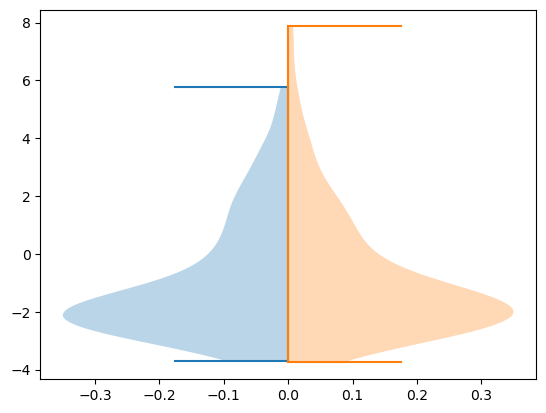

In [30]:
plt.figure()
year = 2100
width = 0.7
gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
# plt.hist(gdp_ref_tmp.values.flatten(), alpha= .5)
# plt.hist(gdp_neg_tmp.values.flatten(), alpha = .5)
plt.violinplot(gdp_ref_tmp.values.flatten(), [0], side = 'low', widths = width,)
plt.violinplot(gdp_neg_tmp.values.flatten(), [0], side = 'high', widths = width)
plt.show()

### Step 5: Visualisations 

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_25550/3610621774.py:85: RuntimeWarning: invalid value encountered in divide
  ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0],
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_25550/3610621774.py:93: RuntimeWarning: invalid value encountered in divide
  ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1],
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_25550/3610621774.py:101: RuntimeWarning: invalid value encountered in divide
  ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9],
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_25550/3610621774.py:110: RuntimeWarning: invalid value encountered in divide
  ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9],
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_25550/3610621774.py:118: RuntimeWarning: invalid value encountered in divide
  ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[

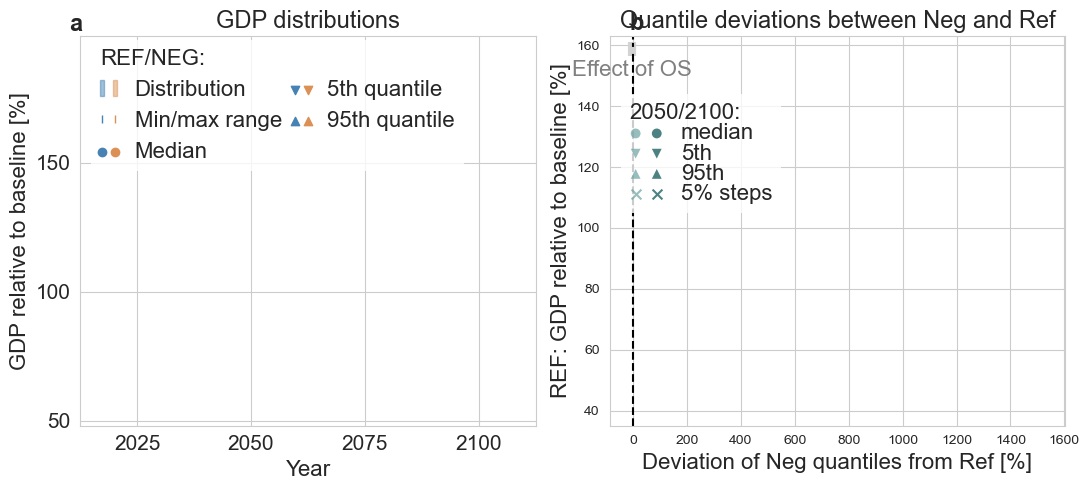

In [ ]:

from matplotlib.legend_handler import HandlerTuple
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Distribution', 'Min/max range', 'Median', '5th quantile', '95th quantile']
    ax.legend(new_handles, 
              new_labels, 
              loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                handlelength = .75,
                ncol = 2,
                title = 'REF/NEG:', 
                title_fontsize = labelsize_medium,
                alignment = 'left',
                bbox_to_anchor = (0, 1.02),
                columnspacing = 0.5,
                )
    ax.set_xlim(-0.5,3.5)
    ax.set_ylim(48, 199)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([50,100,150],[50,100,150], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 201, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 50, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 50, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 50, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['median', '5th', '95th', f'5% steps']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of Neg quantiles from Ref [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([50,100,150], 
                  [50,100,150],
                  fontsize = labelsize_small)
    ax.set_xticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    ax.legend(new_handles, new_labels, loc = 'upper left',
              bbox_to_anchor = (0, 0.88), 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                ncol = 1, 
                columnspacing = 0.7,
                labelspacing = 0.01,
                handlelength = 1.5,
                title = '2050/2100:',
                title_fontsize = labelsize_medium,
                alignment = 'left')
    ax.set_title('Quantile deviations between Neg and Ref',
                 fontsize = labelsize_large)
    ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    ax.plot([-10.5,5.2], [159,159], color = 'lightgrey', linestyle = '-', lw = 3)
    ax.scatter([5.2], [159],  marker = '|', s = 100, color = 'lightgrey', lw = 3)
    ax.scatter([-10.5], [159],  marker = '|', s = 100, color = 'lightgrey', lw = 3)
    ax.text( -3, 152,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey')
    ax.set_ylim(35,163)
    plt.tight_layout()
    plt.savefig(cset.path_GRAPHICS / 'paper' / 'v0' / '003_results.pdf', dpi = 600)
    plt.show()


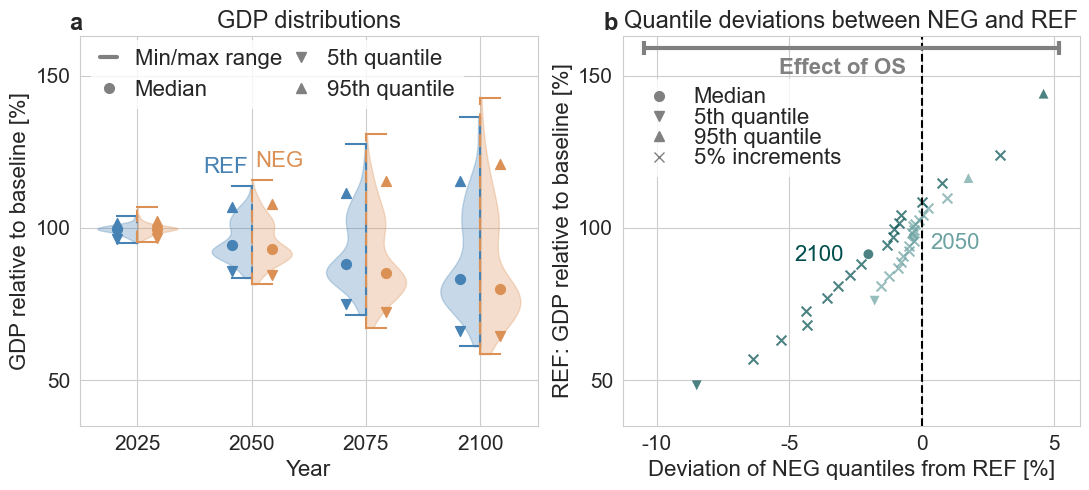

In [10]:

from matplotlib.legend_handler import HandlerTuple
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    handles, labels = ax.get_legend_handles_labels()
    # new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(1,5)]
    import matplotlib.lines as mlines
    minmax_range = mlines.Line2D([], [], color='grey', marker='none', lw = 3,label='Min/max range')
    median = mlines.Line2D([], [], color='grey', marker='o', lw = 0, markersize = 7, label='Median')
    quantile_05 = mlines.Line2D([], [], color='grey', marker='v', lw = 0, markersize = 7, label='5th quantile')
    quantile_95 = mlines.Line2D([], [], color='grey', marker='^', lw = 0, markersize = 7, label='95th quantile')
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Min/max range', 'Median', '5th quantile', '95th quantile']
    ax.legend(handles = [minmax_range, median, quantile_05, quantile_95],
              loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                handlelength = .75,
                ncol = 2,
                alignment = 'left',
                bbox_to_anchor = (0, 1.02),
                columnspacing = 0.5,
                )
    ax.set_xlim(-0.5,3.5)
    # ax.set_ylim(48, 199)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([50,100,150],[50,100,150], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 165, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.text(0.58, 118, 'REF', color = focus_scenarios_color_dict['Ref'], fontsize = labelsize_medium)
    ax.text(1.03, 120, 'NEG', color = focus_scenarios_color_dict['Neg'], fontsize = labelsize_medium)
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    ax.set_ylim(35,163)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 50, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 50, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 50, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['Median', '5th quantile', '95th quantile', f'5% increments']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of NEG quantiles from REF [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([50,100,150], 
                  [50,100,150],
                  fontsize = labelsize_small)
    ax.set_xticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    median = mlines.Line2D([], [], color='grey', marker='o', lw = 0, markersize = 7, label='Median')
    quantile_05 = mlines.Line2D([], [], color='grey', marker='v', lw = 0, markersize = 7, label='5th quantile')
    quantile_95 = mlines.Line2D([], [], color='grey', marker='^', lw = 0, markersize = 7, label='95th quantile')
    steps = mlines.Line2D([], [], color='grey', marker='x', lw = 0, markersize = 7, label='5% increments')
    ax.legend(handles = [median, quantile_05, quantile_95, steps], loc = 'upper left',
              bbox_to_anchor = (0, 0.92), 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                ncol = 1, 
                columnspacing = 0.7,
                labelspacing = 0.01,
                handlelength = 1.5,
                alignment = 'left')
    ax.set_title('Quantile deviations between NEG and REF',
                 fontsize = labelsize_large)
    ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    ax.plot([-10.5,5.2], [159,159], color = 'grey', linestyle = '-', lw = 3)
    ax.scatter([5.2], [159],  marker = '|', s = 100, color = 'grey', lw = 3)
    ax.scatter([-10.5], [159],  marker = '|', s = 100, color = 'grey', lw = 3)
    ax.text( -3, 152.5,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey', fontweight = 'bold')
    ax.text(-4.8, 89, '2100', color = colors[1], fontsize = labelsize_medium, ha = 'left')
    ax.text(2.2, 93, '2050', color = colors[0], fontsize = labelsize_medium, ha = 'right')
    ax.set_ylim(35,163)
    plt.tight_layout()
    plt.savefig(cset.path_GRAPHICS / '003_results.pdf', dpi = 600)
    plt.show()